# **LOAD DATA**

Mengimpor modul files dari google.colab dan menjalankan fungsi files.upload() untuk memungkinkan pengguna mengunggah file lokal (misalnya, kaggle.json) ke lingkungan Google Colab.

In [1]:
from google.colab import files
files.upload()  # Upload kaggle.json di sini

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"yuliantoaryaseta","key":"a6fa6b69246c8dc275ec2b3c6594245c"}'}

Membuat direktori untuk menyimpan file konfigurasi API Kaggle, menyalin kredensial API, mengunduh dataset "predict-students-dropout-and-academic-success" dari Kaggle, dan mengekstraknya untuk digunakan dalam analisis.

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download dataset
!kaggle datasets download -d adilshamim8/predict-students-dropout-and-academic-success

# Unzip file
!unzip predict-students-dropout-and-academic-success.zip


Dataset URL: https://www.kaggle.com/datasets/adilshamim8/predict-students-dropout-and-academic-success
License(s): Attribution 4.0 International (CC BY 4.0)
Archive:  predict-students-dropout-and-academic-success.zip
  inflating: students_dropout_academic_success.csv  


# **IMPORT LIBRARY**

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# **DATA UNDERSTANDING**

Memuat dataset dari file CSV

In [4]:
df = pd.read_csv("/content/students_dropout_academic_success.csv")

Menampilkan preview dataset, dari kode ini sekilas kita bisa melihat bahwa ada 4424 baris dan 37 kolom.

In [5]:
df

,Marital Status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,target
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4419,1,1,6,9773,1,1,125.0,1,1,1,...,0,6,8,5,12.666667,0,15.5,2.8,-4.06,Graduate
4420,1,1,2,9773,1,1,120.0,105,1,1,...,0,6,6,2,11.000000,0,11.1,0.6,2.02,Dropout
4421,1,1,1,9500,1,1,154.0,1,37,37,...,0,8,9,1,13.500000,0,13.9,-0.3,0.79,Dropout
4422,1,1,1,9147,1,1,180.0,1,37,37,...,0,5,6,5,12.000000,0,9.4,-0.8,-3.12,Graduate


Menampilkan nama-nama kolom dalam DataFrame df.

In [6]:
print(df.columns)

Index(['Marital Status', 'Application mode', 'Application order', 'Course',
       'Daytime/evening attendance', 'Previous qualification',
       'Previous qualification (grade)', 'Nacionality',
       'Mother's qualification', 'Father's qualification',
       'Mother's occupation', 'Father's occupation', 'Admission grade',
       'Displaced', 'Educational special needs', 'Debtor',
       'Tuition fees up to date', 'Gender', 'Scholarship holder',
       'Age at enrollment', 'International',
       'Curricular units 1st sem (credited)',
       'Curricular units 1st sem (enrolled)',
       'Curricular units 1st sem (evaluations)',
       'Curricular units 1st sem (approved)',
       'Curricular units 1st sem (grade)',
       'Curricular units 1st sem (without evaluations)',
       'Curricular units 2nd sem (credited)',
       'Curricular units 2nd sem (enrolled)',
       'Curricular units 2nd sem (evaluations)',
       'Curricular units 2nd sem (approved)',
       'Curricular units 2nd s

Menampilkan informasi tentang DataFrame df, termasuk tipe data setiap kolom dan jumlah data non-null. Dari kode ini kita bisa melihat bahwa semua kolom bertipe data numerik (int/float) dan hanya kolom target yang bertipe data object

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 37 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Marital Status                                  4424 non-null   int64  
 1   Application mode                                4424 non-null   int64  
 2   Application order                               4424 non-null   int64  
 3   Course                                          4424 non-null   int64  
 4   Daytime/evening attendance                      4424 non-null   int64  
 5   Previous qualification                          4424 non-null   int64  
 6   Previous qualification (grade)                  4424 non-null   float64
 7   Nacionality                                     4424 non-null   int64  
 8   Mother's qualification                          4424 non-null   int64  
 9   Father's qualification                   

Menampilkan statistik deskriptif dari kolom-kolom numerik dalam DataFrame df, seperti mean, standar deviasi, nilai minimum, dan nilai maksimum.

In [8]:
df.describe()

,Marital Status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 1st sem (without evaluations),Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP
count,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,...,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000
mean,1.178571,18.669078,1.727848,8856.642631,0.890823,4.577758,132.613314,1.873192,19.561935,22.275316,...,0.137658,0.541817,6.232143,8.063291,4.435805,10.230206,0.150316,11.566139,1.228029,0.001969
std,0.605747,17.484682,1.313793,2063.566416,0.311897,10.216592,13.188332,6.914514,15.603186,15.343108,...,0.690880,1.918546,2.195951,3.947951,3.014764,5.210808,0.753774,2.663850,1.382711,2.269935
min,1.000000,1.000000,0.000000,33.000000,0.000000,1.000000,95.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.600000,-0.800000,-4.060000
25%,1.000000,1.000000,1.000000,9085.000000,1.000000,1.000000,125.000000,1.000000,2.000000,3.000000,...,0.000000,0.000000,5.000000,6.000000,2.000000,10.750000,0.000000,9.400000,0.300000,-1.700000
50%,1.000000,17.000000,1.000000,9238.000000,1.000000,1.000000,133.100000,1.000000,19.000000,19.000000,...,0.000000,0.000000,6.000000,8.000000,5.000000,12.200000,0.000000,11.100000,1.400000,0.320000
75%,1.000000,39.000000,2.000000,9556.000000,1.000000,1.000000,140.000000,1.000000,37.000000,37.000000,...,0.000000,0.000000,7.000000,10.000000,6.000000,13.333333,0.000000,13.900000,2.600000,1.790000
max,6.000000,57.000000,9.000000,9991.000000,1.000000,43.000000,190.000000,109.000000,44.000000,44.000000,...,12.000000,19.000000,23.000000,33.000000,20.000000,18.571429,12.000000,16.200000,3.700000,3.510000


Membuat heatmap matriks korelasi untuk fitur numerik. Ini membantu dalam memahami hubungan antar fitur numerik dalam dataset.

Text(0.5, 1.0, 'Correlation Matrix untuk Fitur Numerik ')

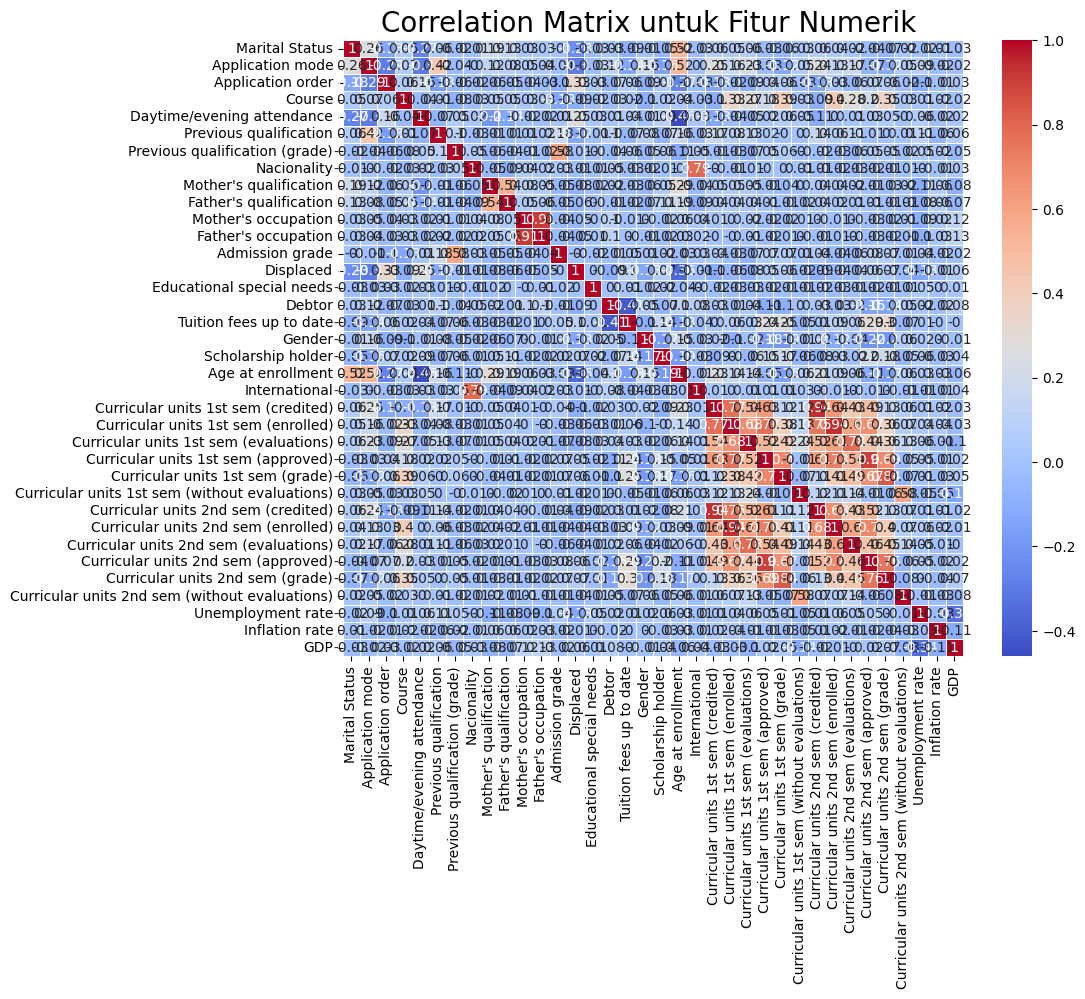

In [9]:
numerical_features = [
    'Marital Status',
    'Application mode',
    'Application order',
    'Course',
    'Daytime/evening attendance',
    'Previous qualification',
    'Previous qualification (grade)',
    'Nacionality',
    "Mother's qualification",
    "Father's qualification",
    "Mother's occupation",
    "Father's occupation",
    "Admission grade",
    'Displaced',
    'Educational special needs',
    'Debtor',
    'Tuition fees up to date',
    'Gender',
    'Scholarship holder',
    'Age at enrollment',
    'International',
    'Curricular units 1st sem (credited)',
    'Curricular units 1st sem (enrolled)',
    'Curricular units 1st sem (evaluations)',
    'Curricular units 1st sem (approved)',
    'Curricular units 1st sem (grade)',
    'Curricular units 1st sem (without evaluations)',
    'Curricular units 2nd sem (credited)',
    'Curricular units 2nd sem (enrolled)',
    'Curricular units 2nd sem (evaluations)',
    'Curricular units 2nd sem (approved)',
    'Curricular units 2nd sem (grade)',
    'Curricular units 2nd sem (without evaluations)',
    'Unemployment rate',
    'Inflation rate',
    'GDP'
]
plt.figure(figsize=(10, 8))
correlation_matrix = df[numerical_features].corr().round(2)

# Untuk menge-print nilai di dalam kotak, gunakan parameter anot=True
sns.heatmap(data=correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, )
plt.title("Correlation Matrix untuk Fitur Numerik ", size=20)

Membuat histogram untuk setiap kolom numerik dalam DataFrame df. Histogram ini memberikan gambaran tentang distribusi data untuk setiap fitur.

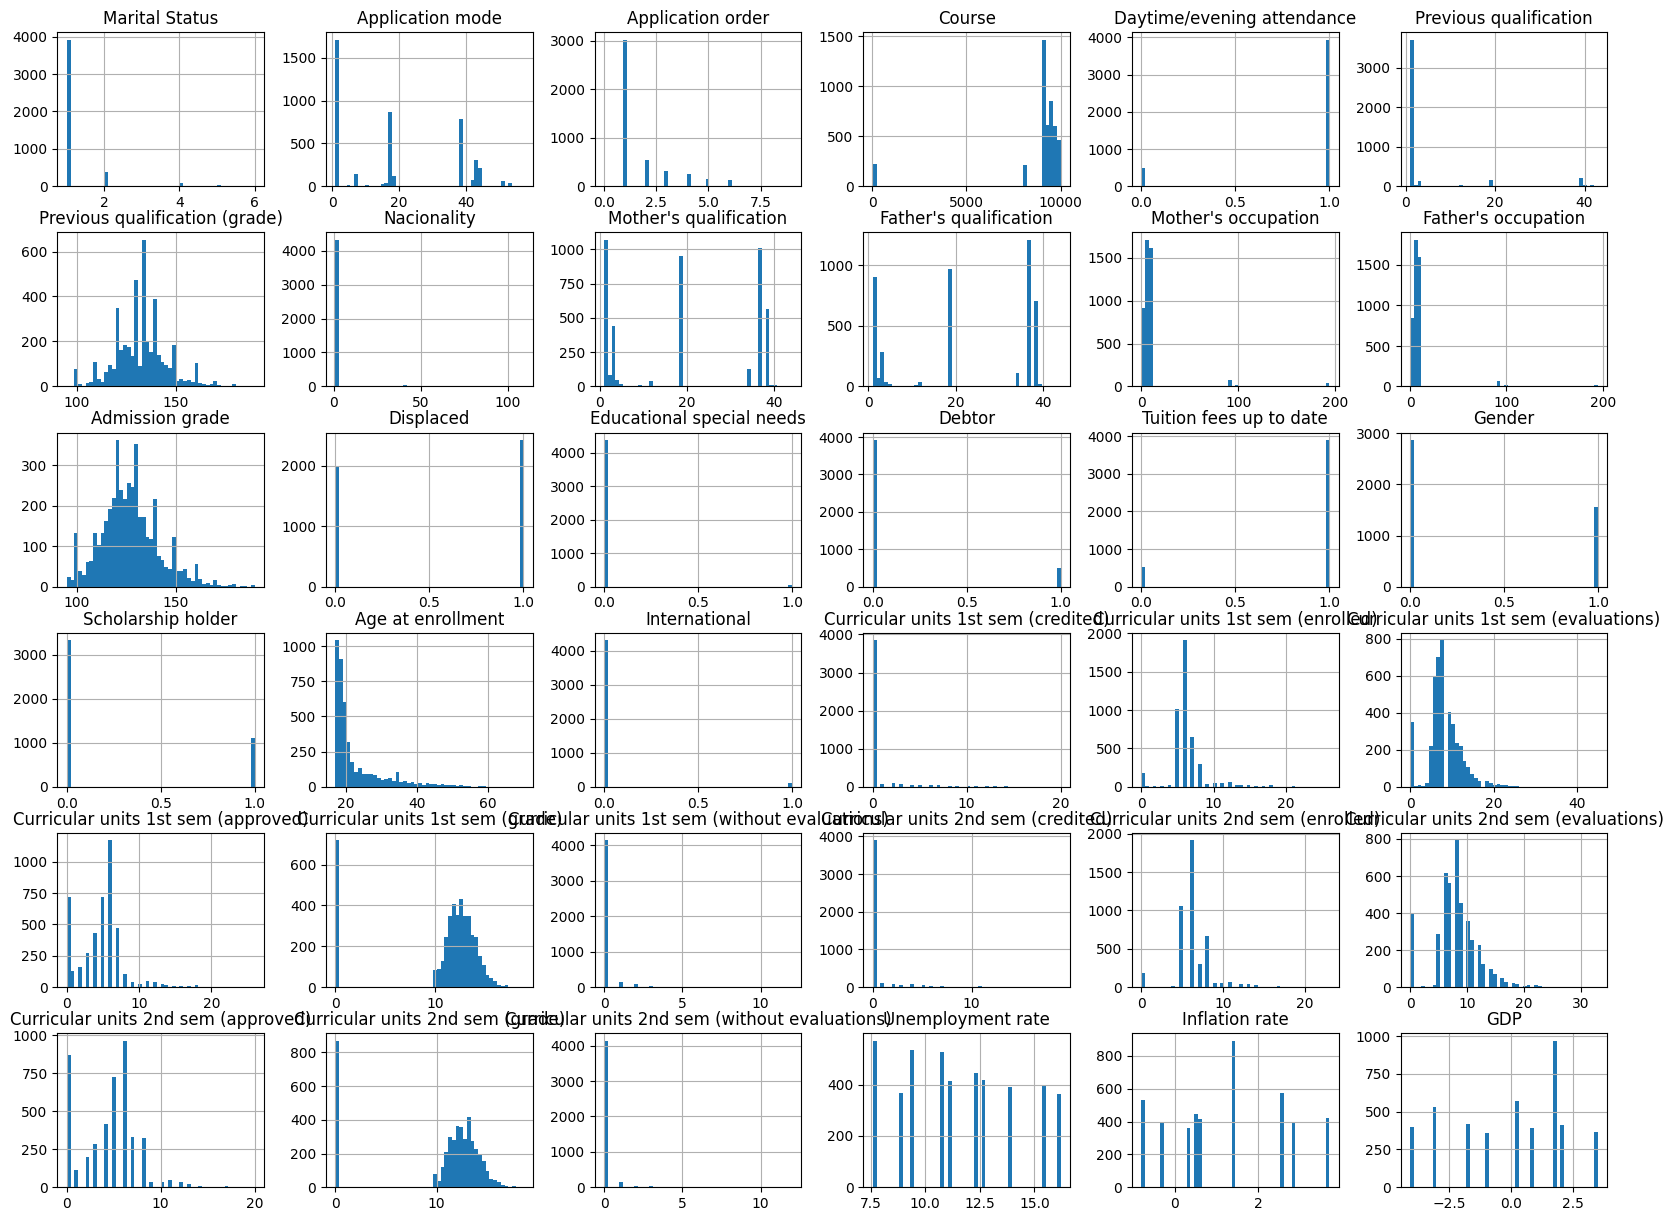

In [10]:
df.hist(bins=50, figsize=(20,15))
plt.show()

Membuat count plot untuk kolom 'target'. Ini menunjukkan distribusi kelas target (Dropout, Enrolled, Graduate) dalam dataset. Terlihat ada pebedaan  jumlah yang sangat signifikan dari ketiga kelas, hal ini nantinya akan dilakukan penyeimbangan kelas dengan teknik SMOTE

<ipython-input-11-7dd5eeb4d71b>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x='target', palette='viridis')


Text(0, 0.5, 'Number of Students')

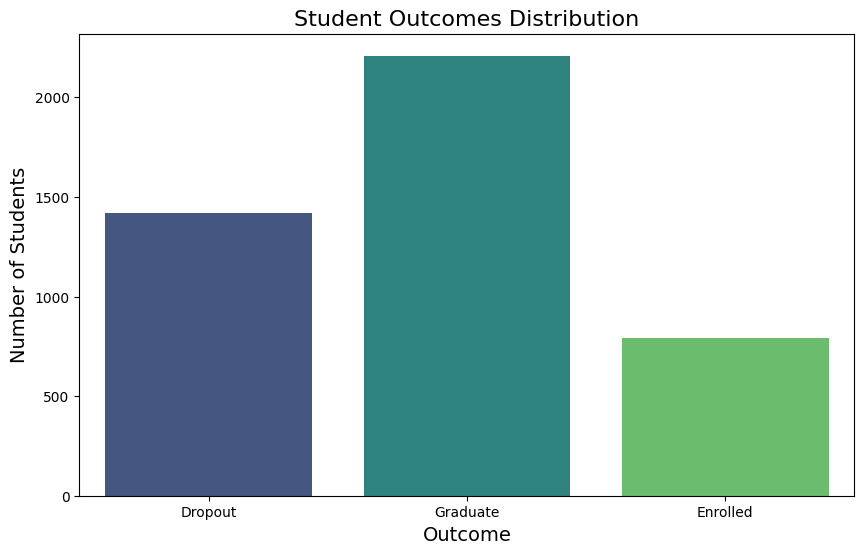

In [11]:
# Target distribution
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=df, x='target', palette='viridis')
plt.title('Student Outcomes Distribution', fontsize=16)
plt.xlabel('Outcome', fontsize=14)
plt.ylabel('Number of Students', fontsize=14)

Memeriksa dan menampilkan jumlah missing values (nilai yang hilang) di setiap kolom DataFrame df. Karena tidak ada missing values maka kita biarkan saja seperti ini.

In [12]:
# Melihat apakah ada missing values
missing_values = df.isnull().sum()
print("\nMissing values per column:")
print(missing_values[missing_values > 0]) if any(missing_values > 0) else print("No missing values found.")


Missing values per column:
No missing values found.


Memeriksa dan menampilkan jumlah baris duplikat dalam DataFrame df. Karena tidak ada baris duplikat maka kita biarkan saja seperti ini

In [13]:
# Melihat apakah ada duplikasi data
duplicates = df.duplicated().sum()
print(f"\nDuplicate rows: {duplicates}")


Duplicate rows: 0


Mendeteksi dan menampilkan outlier (nilai ekstrem) dalam kolom-kolom numerik kontinu menggunakan metode Interquartile Range (IQR). Output menunjukkan jumlah dan persentase data outlier dalam berbagai variabel akademik dan demografis, dengan proporsi outlier tertinggi pada variabel seperti "Curricular units 1st sem (grade)" dan "Curricular units 2nd sem (grade)", serta sejumlah variabel tanpa outlier, seperti tingkat pengangguran dan inflasi.

In [14]:
# Pilih kolom float saja
continuous = df.select_dtypes(include='float64').columns.tolist()

# Atau: kolom int dengan >10 unique values
int_cols = df.select_dtypes(include='int64').nunique()
cont_int = int_cols[int_cols > 10].index.tolist()

numeric_continuous = continuous + cont_int
for col in numeric_continuous:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers_count = df[(df[col] < lower_bound) | (df[col] > upper_bound)].shape[0]
    outlier_pct = outliers_count / len(df) * 100
    print(f"{col}: {outliers_count} outliers ({outlier_pct:.2f}%)")

Previous qualification (grade): 179 outliers (4.05%)
Admission grade: 86 outliers (1.94%)
Curricular units 1st sem (grade): 726 outliers (16.41%)
Curricular units 2nd sem (grade): 877 outliers (19.82%)
Unemployment rate: 0 outliers (0.00%)
Inflation rate: 0 outliers (0.00%)
GDP: 0 outliers (0.00%)
Application mode: 0 outliers (0.00%)
Course: 442 outliers (9.99%)
Previous qualification: 707 outliers (15.98%)
Nacionality: 110 outliers (2.49%)
Mother's qualification: 0 outliers (0.00%)
Father's qualification: 0 outliers (0.00%)
Mother's occupation: 182 outliers (4.11%)
Father's occupation: 177 outliers (4.00%)
Age at enrollment: 441 outliers (9.97%)
Curricular units 1st sem (credited): 577 outliers (13.04%)
Curricular units 1st sem (enrolled): 424 outliers (9.58%)
Curricular units 1st sem (evaluations): 158 outliers (3.57%)
Curricular units 1st sem (approved): 180 outliers (4.07%)
Curricular units 1st sem (without evaluations): 294 outliers (6.65%)
Curricular units 2nd sem (credited): 530

# **DATA PREPARATION**

Melakukan penanganan outlier pada kolom-kolom numerik kontinu yang telah dievaluasi sebelumnya dengan menghitung batas bawah dan atas menggunakan metode Interquartile Range (IQR), lalu membatasi nilai-nilai ekstrem (outlier) dalam rentang tersebut menggunakan clip(), sehingga nilai yang terlalu rendah atau terlalu tinggi dikonversi ke batas bawah atau atas, menjaga distribusi data tanpa membuang sampel.

In [15]:
# Cap outliers for key columns
print("Memperbaiki nilai outliers untuk kolom continous")
for col in numeric_continuous:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = max(Q1 - 1.5 * IQR, 0)  # Don't go below 0 for grades
    upper_bound = Q3 + 1.5 * IQR

    # Cap outliers instead of removing them
    df[col] = df[col].clip(lower_bound, upper_bound)

    print(f"Column {col} capped between {lower_bound:.2f} and {upper_bound:.2f}")

Memperbaiki nilai outliers untuk kolom continous
Column Previous qualification (grade) capped between 102.50 and 162.50
Column Admission grade capped between 92.55 and 160.15
Column Curricular units 1st sem (grade) capped between 7.40 and 17.00
Column Curricular units 2nd sem (grade) capped between 6.88 and 17.21
Column Unemployment rate capped between 2.65 and 20.65
Column Inflation rate capped between 0.00 and 6.05
Column GDP capped between 0.00 and 7.03
Column Application mode capped between 0.00 and 96.00
Column Course capped between 8378.50 and 10262.50
Column Previous qualification capped between 1.00 and 1.00
Column Nacionality capped between 1.00 and 1.00
Column Mother's qualification capped between 0.00 and 89.50
Column Father's qualification capped between 0.00 and 88.00
Column Mother's occupation capped between 0.00 and 16.50
Column Father's occupation capped between 0.00 and 16.50
Column Age at enrollment capped between 10.00 and 34.00
Column Curricular units 1st sem (credi

Memisahkan fitur (kolom) numerik dan kategorikal dalam sebuah DataFrame (df) agar bisa dilakukan pembersihan atau pemrosesan data secara spesifik sesuai tipe datanya.

In [16]:
# Pisahkan fitur numerik dan kategorikal
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

Membersihkan kolom-kolom kategorikal dalam DataFrame dengan mengidentifikasi dan mengganti kategori langka—yaitu kategori dengan proporsi kemunculan kurang dari 1%—menjadi label 'Other', menggunakan fungsi remove_rare_categories() yang diterapkan ke setiap kolom dalam daftar categorical_cols

In [17]:
# Kategorikal Cleaning: hapus kategori langka (< 1%)
def remove_rare_categories(df, col, threshold=0.01):
    value_counts = df[col].value_counts(normalize=True)
    common_categories = value_counts[value_counts > threshold].index
    df[col] = df[col].apply(lambda x: x if x in common_categories else 'Other')
    return df

for col in categorical_cols:
    df = remove_rare_categories(df, col)

Melakukan normalisasi (scaling) terhadap kolom-kolom numerik dalam DataFrame menggunakan StandardScaler, yang mengubah distribusi data sehingga setiap fitur memiliki nilai rata-rata 0 dan standar deviasi 1

In [18]:
# Scaling / Normalization
scaler = StandardScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

Mempersiapkan fitur (X) dengan menghapus kolom 'target' dari DataFrame, lalu mengenali dan mengubah nilai kategorikal pada kolom 'target' menjadi angka menggunakan LabelEncoder

Target classes: {'Dropout': 0, 'Enrolled': 1, 'Graduate': 2}

In [19]:
# Prepare features and target
X = df.drop('target', axis=1)

# Encode target
le = LabelEncoder()
y = le.fit_transform(df['target'])
print(f"Target classes: {dict(zip(le.classes_, range(len(le.classes_))))}")

Target classes: {'Dropout': 0, 'Enrolled': 1, 'Graduate': 2}


Membagi dataset menjadi data pelatihan (X_train, y_train) dan data pengujian (X_test, y_test) dengan proporsi 90% untuk pelatihan dan 10% untuk pengujian, menggunakan train_test_split dengan random_state=42 untuk reprodusibilitas dan stratify=y agar distribusi kelas pada data target tetap seimbang di kedua subset

In [20]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)
print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

Training set: 3981 samples
Test set: 443 samples


Menerapkan teknik SMOTE (Synthetic Minority Over-sampling Technique) pada data pelatihan untuk mengatasi ketidakseimbangan kelas dengan menghasilkan sampel sintetis pada kelas minoritas, sehingga X_train_res dan y_train_res menjadi data pelatihan yang telah seimbang dari segi distribusi kelas.

In [21]:
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

# **MODEL DEVELOPMENT**

Membuat model XGBClassifier dengan menggunakan parameter default.

In [22]:
# Gunakan XGBClassifier
model = XGBClassifier()
model.fit(X_train_res, y_train_res)

# Prediksi dan evaluasi
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.781038374717833
              precision    recall  f1-score   support

           0       0.84      0.75      0.80       142
           1       0.50      0.51      0.51        80
           2       0.85      0.90      0.87       221

    accuracy                           0.78       443
   macro avg       0.73      0.72      0.72       443
weighted avg       0.78      0.78      0.78       443



# **INSIGHT**

Mengekstrak dan menampilkan apa saja fitur-fitur penting yang paling berpengaruh dalam hasil akhir mahasiswa

In [23]:
# Feature importance
feat_importances = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False)

Model XGBClassifier menunjukkan bahwa 5 faktor paling berpengaruh dalam memprediksi hasil mahasiswa adalah jumlah mata kuliah yang lulus di semester kedua, status pembayaran biaya kuliah, serta jumlah mata kuliah yang diambil dan lulus di semester pertama dan kedua.

In [24]:
print("\n Top 5 factors predicting student outcomes:")
for i, (feature, importance) in enumerate(zip(feat_importances['Feature'].head(5), feat_importances['Importance'].head(5))):
    print(f"{i+1}. {feature}: {importance:.4f}")


 Top 5 factors predicting student outcomes:
1. Curricular units 2nd sem (approved): 0.1907
2. Tuition fees up to date: 0.1583
3. Curricular units 2nd sem (enrolled): 0.0581
4. Curricular units 1st sem (enrolled): 0.0409
5. Curricular units 1st sem (approved): 0.0391


Plotting untuk menampilkan fitur-fitur lainnya

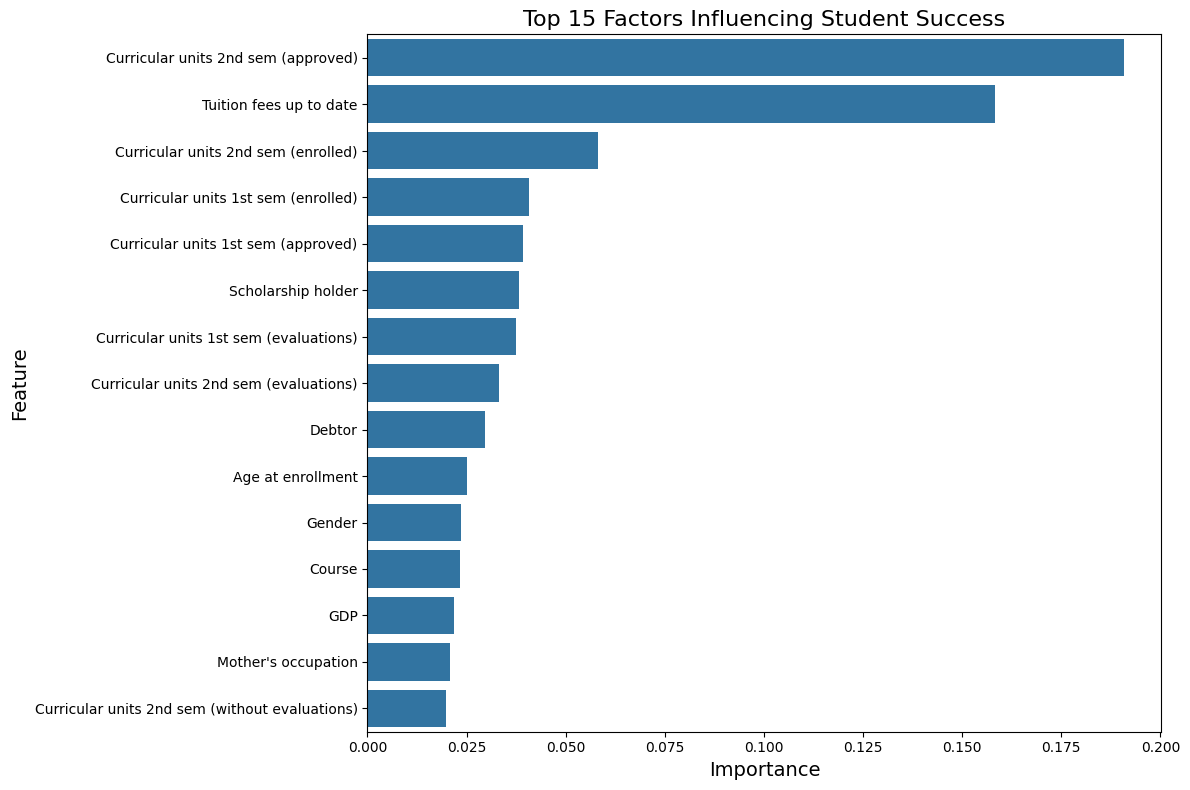

In [25]:
# Visualisasi top 15 fitur
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feat_importances.head(15))
plt.title('Top 15 Factors Influencing Student Success', fontsize=16)
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.tight_layout()
plt.show()

# **EVALUATION & COMPARATION**

Empat model klasifikasi dilatih dan dievaluasi untuk membandingkan performa prediksi hasil mahasiswa, dengan pendekatan ensemble (XGBoost dan Random Forest), model linier (Logistic Regression), dan instance-based (KNN).

In [26]:
models = {
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
    "Random Forest": RandomForestClassifier(),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "KNN": KNeighborsClassifier(),
}

# List for storing accuracy and classification report
accuracies = []
reports = []

# Train and evaluate each model
for name, model in models.items():
    model.fit(X_train_res, y_train_res)  # Train model
    y_pred = model.predict(X_test)  # Predict on test set
    acc = accuracy_score(y_test, y_pred)  # Calculate accuracy
    accuracies.append(acc)
    reports.append(classification_report(y_test, y_pred, output_dict=True))  # Store detailed report


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:29:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost memberikan hasil prediksi terbaik secara keseluruhan, terutama pada kelas mayoritas, diikuti oleh Random Forest dan Logistic Regression. KNN menunjukkan performa paling rendah dan kurang efektif untuk digunakan pada kasus ini.

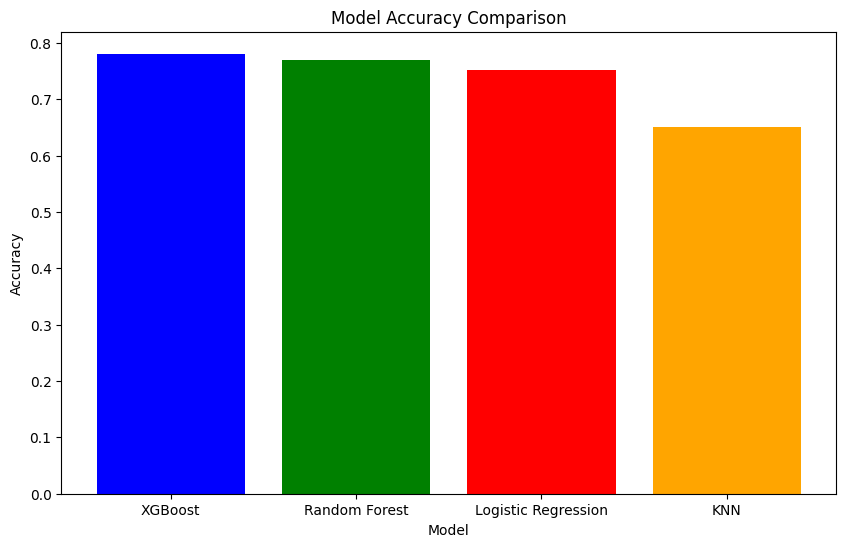


XGBoost Classification Report:
--------------------------------------------------
{'0': {'precision': 0.84251968503937, 'recall': 0.7535211267605634, 'f1-score': 0.7955390334572491, 'support': 142.0}, '1': {'precision': 0.5, 'recall': 0.5125, 'f1-score': 0.5061728395061729, 'support': 80.0}, '2': {'precision': 0.8461538461538461, 'recall': 0.8959276018099548, 'f1-score': 0.8703296703296703, 'support': 221.0}, 'accuracy': 0.781038374717833, 'macro avg': {'precision': 0.729557843731072, 'recall': 0.7206495761901727, 'f1-score': 0.7240138477643642, 'support': 443.0}, 'weighted avg': {'precision': 0.7824780931728905, 'recall': 0.781038374717833, 'f1-score': 0.7805941919961181, 'support': 443.0}}

Random Forest Classification Report:
--------------------------------------------------
{'0': {'precision': 0.848, 'recall': 0.7464788732394366, 'f1-score': 0.7940074906367042, 'support': 142.0}, '1': {'precision': 0.47058823529411764, 'recall': 0.5, 'f1-score': 0.48484848484848486, 'support': 80

In [27]:
# Plotting the accuracy for each model
plt.figure(figsize=(10, 6))
plt.bar(models.keys(), accuracies, color=['blue', 'green', 'red', 'orange'])
plt.title("Model Accuracy Comparison")
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.show()

# Display classification reports for each model
for name, report in zip(models.keys(), reports):
    print(f"\n{name} Classification Report:")
    print("--------------------------------------------------")
    print(report)